In [6]:
import numpy as np
import matplotlib.pylab as plt
import math
%matplotlib inline

# fixing random seed
np.random.seed(42)

# MNIST handwritten digit dataset

In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', data_home='./')
X = mnist['data']
print(X.shape)

(70000, 784)


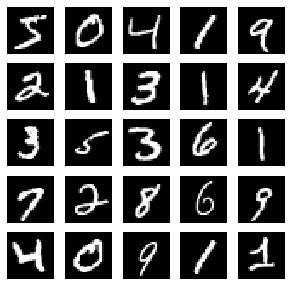

In [8]:
n = 5
fig, axs = plt.subplots(n, n, figsize = (n,n))

for wi in range(n):
    for wj in range(n):

        axs[wi, wj].axis('off')
        axs[wi, wj].imshow(X[wi*n+wj].reshape(28,28), cmap='gray')            

In [9]:
# data normalization
X = X.astype('float')
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X-mean) / (std + 1e-3)

In [11]:
# Labels conversion to one-hot encoding and train-test splitting

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Y = mnist['target']
idxs = np.where((Y == '0') | (Y == '3' ) | (Y == '7'))

X_n = X[idxs]
Y_n = Y[idxs]

print('original', Y_n)
t = OneHotEncoder(sparse=False, categories='auto')
Y_work = t.fit_transform(Y_n.reshape(-1, 1))
print('one hot', Y_work)
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y_work, test_size=0.2, stratify=Y_n)
print('X train shape :', X_train.shape, ', Labels train shape :', Y_train.shape,
     '\nX test shape :', X_test.shape, ', Labels test shape :', Y_train.shape)

original ['0' '3' '3' ... '7' '0' '3']
one hot [[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
X train shape : (17069, 784) , Labels train shape : (17069, 3) 
X test shape : (4268, 784) , Labels test shape : (17069, 3)


In [14]:
class Dense:
    def __init__(self, in_size, out_size):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros((out_size,1))
        
    def forward(self, x):
        
        self.x = x #remember x for backward path
#         YOUR CODE HERE
        z = self.W @ x + self.b
#         YOUR CODE HERE        
        return z
    
    def backward(self, dz):
        
        N = self.x.shape[1] #number of examples in the training set
        # gradients calculation
#         YOUR CODE HERE
        self.dW = (dz @ self.x.T) /N
        self.db = dz.sum(axis=1, keepdims=True) / N
        self.dx = self.W.T @ dz
#         YOUR CODE HERE
        
        return self.dx, (self.dW, self.db)
    
    def update(self, lr):
        
#         YOUR CODE HERE
        self.W += -lr * self.dW
        self.b += -lr * self.db
#         YOUR CODE HERE

        return 

In [15]:
x_test = np.random.randn(3,5)
dense = Dense(5,2)
output = dense.forward(x_test.T)

out_shape = output.shape
print('output_shape :',out_shape)
print('should be :', (2,3))

if out_shape == (2,3):
    print('Forward test passed')

dz = np.random.randn(2,3)
dx, (dW, db) = dense.backward(dz)

if (dx.shape == x_test.T.shape)*(dW.shape == dense.W.shape)*(db.shape == dense.b.shape):
    print('Bacward test passed')

output_shape : (2, 3)
should be : (2, 3)
Forward test passed
Bacward test passed


In [16]:
class Max:
    def forward(self, x):
        self.x = x #remember x of backward path
#         YOUR CODE HERE
        activation = np.maximum(0,x)

#         YOUR CODE HERE
        
        return activation
    
    def backward(self, dz):
        dz[self.x < 0] = 0
        return dz

In [17]:
relu = Max()

output = relu.forward(output)
out_shape = output.shape
print('output_shape :',out_shape)
print('should be :', (2,3))

if out_shape == (2,3):
    print('Forward test passed')
    
dz = np.random.randn(2,3)
if relu.backward(dz).shape == (dz.shape):
    print('Bacward test passed')

output_shape : (2, 3)
should be : (2, 3)
Forward test passed
Bacward test passed


In [27]:
class Softmax_Cross_entropy:
    
    def forward(self, y_true, x):
        m = x.shape[1]
        self.x = x
        self.y = y_true
#         YOUR CODE HERE
        exps = np.exp(x-x.max())
        self.sm = exps/np.sum(exps,axis=0,keepdims=True)
        self.ce = - (self.y * np.log(self.sm)).sum()/m
#         YOUR CODE HERE
        
        return self.sm, self.ce
    
    def backward(self): 
        
#         YOUR CODE HERE
        delta_z = self.sm - self.y
#         YOUR CODE HERE
        return delta_z

In [28]:
cost = Softmax_Cross_entropy()

In [29]:
sm, ce = cost.forward(dz, output)
if sm.shape == dz.shape and ce.shape == ():
    print('Forward test passed')
    
if cost.backward().shape == dz.shape:
    print('Backward test passed')

Forward test passed
Backward test passed


In [30]:
class MnistNet:
    
    def __init__(self):
        
        self.grads_tape = []
        
        self.dense_1 = Dense(784, 20)
        self.relu = Max()
        self.dense_2 = Dense(20, 3)
        self.cost = Softmax_Cross_entropy()
    
    def forward(self, x, y_true):
        
        z = self.dense_1.forward(x)
        a = self.relu.forward(z)
        z = self.dense_2.forward(a)
        self.y_hat, loss = self.cost.forward(y_true, z)
        
        return self.y_hat, loss
    
    def backward(self):
        
        dz = self.cost.backward()
        dz, grads_2 = self.dense_2.backward(dz)
#         self.grads_tape.append(grads_2)
        
        dz = self.relu.backward(dz)
        dz, grads_1 = self.dense_1.backward(dz)
#         self.grads_tape.append(grads_1)
        
        return dz
    
    def update(self, lr):
        
        self.dense_1.update(lr)
        self.dense_2.update(lr)

In [31]:
def calculate_accuracy(pred_one_hot, label_one_hot):
    
    prediction = np.argmax(pred_one_hot.T, axis=1)
    labels = np.argmax(label_one_hot, axis=1)
    
    acc = ((prediction - labels) == 0).sum()/label_one_hot.sum()
    
    return acc

In [32]:
net = MnistNet()
lr = 0.02
loss_train, loss_test, acc_train, acc_test = [], [], [], []

for epoch in range(100):
    L_acc = 0.
    y_train_temp, loss_train_temp = net.forward(X_train.T, Y_train.T)
    net.backward()
    net.update(lr = lr)
    
    loss_train.append(loss_train_temp)  
    train_acc_temp = calculate_accuracy(y_train_temp, Y_train)
    acc_train.append(train_acc_temp)
    
    y_test_temp, loss_test_temp = net.forward(X_test.T, Y_test.T)
    loss_test.append(loss_test_temp)
    test_acc_temp = calculate_accuracy(y_test_temp, Y_test)
    acc_test.append(test_acc_temp)
    
    if epoch % 10 == 0:
        print("{} epoch loss. Train : {}, Test : {}\n acc. Train : {}, Test : {}".format(epoch, 
                                                            np.round(loss_train_temp,2),
                                                            np.round(loss_test_temp,2),
                                                            np.round(train_acc_temp,2),
                                                            np.round(test_acc_temp,2)))

0 epoch loss. Train : 1.28, Test : 1.09
 acc. Train : 0.38, Test : 0.49
10 epoch loss. Train : 0.47, Test : 0.46
 acc. Train : 0.89, Test : 0.9
20 epoch loss. Train : 0.29, Test : 0.3
 acc. Train : 0.94, Test : 0.94
30 epoch loss. Train : 0.22, Test : 0.23
 acc. Train : 0.95, Test : 0.95
40 epoch loss. Train : 0.18, Test : 0.19
 acc. Train : 0.96, Test : 0.96
50 epoch loss. Train : 0.16, Test : 0.17
 acc. Train : 0.96, Test : 0.96
60 epoch loss. Train : 0.14, Test : 0.15
 acc. Train : 0.96, Test : 0.96
70 epoch loss. Train : 0.13, Test : 0.14
 acc. Train : 0.97, Test : 0.97
80 epoch loss. Train : 0.12, Test : 0.13
 acc. Train : 0.97, Test : 0.97
90 epoch loss. Train : 0.11, Test : 0.13
 acc. Train : 0.97, Test : 0.97


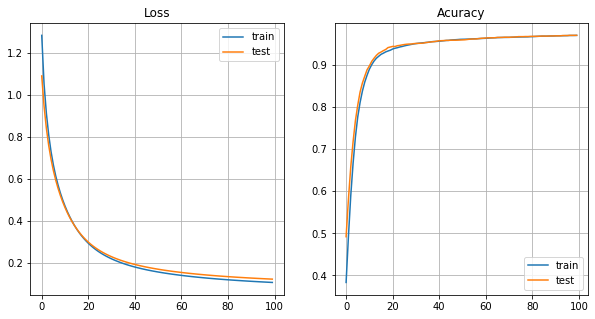

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

ax1.plot(loss_train, label='train')
ax1.plot(loss_test, label='test')
ax1.grid()
ax1.set_title('Loss')
ax1.legend()

ax2.plot(acc_train, label='train')
ax2.plot(acc_test, label='test')
ax2.grid()
ax2.set_title('Acuracy')
ax2.legend()

plt.show()

In [34]:
prediction = np.argmax(y_test_temp.T, axis=1)
true_labels = np.argmax(Y_test, axis=1)
correct = np.where(prediction - true_labels == 0)[0]
mistake = np.where(prediction - true_labels != 0)[0]

In [35]:
true_dict = {'0':0,'1':3,'2':7}

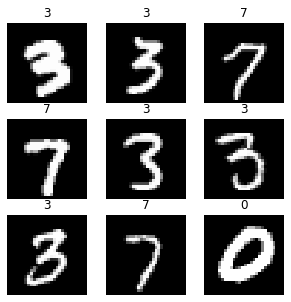

In [36]:
X_test_correct = (X_test*std + mean)[correct]
pred_correct = prediction[correct]

n = 3
fig, axs = plt.subplots(n, n, figsize = (5,5))

for wi in range(n):
    for wj in range(n):

        axs[wi, wj].axis('off')
        axs[wi, wj].imshow(X_test_correct[wi*n+wj].reshape(28,28), cmap='gray')  
        axs[wi, wj].set_title(true_dict[str(pred_correct[wi*n+wj])])

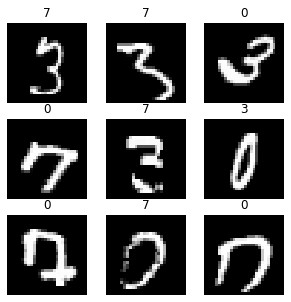

In [37]:
X_test_wrong = (X_test*std + mean)[mistake]
pred_wrong = prediction[mistake]

n = 3
fig, axs = plt.subplots(n, n, figsize = (5,5))

for wi in range(n):
    for wj in range(n):

        axs[wi, wj].axis('off')
        axs[wi, wj].imshow(X_test_wrong[wi*n+wj].reshape(28,28), cmap='gray')  
        axs[wi, wj].set_title(true_dict[str(pred_wrong[wi*n+wj])])

# HW

#### Do:
1) Several hidden layers
2) MNIST digits classification with all 10 classes. Reach at least 96 % accuracy on the test set